<a href="https://colab.research.google.com/github/phyop/220505_TensorFlow2/blob/main/220419_CNN%E6%87%89%E7%94%A8%E4%BA%8E%E6%96%87%E6%9C%AC%E4%BB%BB%E5%8B%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
https://www.bilibili.com/video/BV1w44y1k7X6?p=72

CNN的輸入是(batch, height, width, channel)，
所以如果把文本也變成這樣的格式做輸入，那就也可以用CNN的模型來訓練文本了。
所以可以把原本圖像conv的3*3或5*5，改成1*5(1個詞*5維詞向量)之類的就好了。

但接連而來的問題是，word是有先後順序的，那這就和圖像有根本上的區別了啊！
以7*5的input， "I like this movie very much !" 來說，
如果改成2*5(2個詞*5維詞向量)之類的，
這樣I like這兩個詞就會有先後的關係被連在一起了。
以1個詞的步長去走，那下次關聯的詞就會變成like this，
再下次就是this movie，
那words之間的關聯性就建立起來了。

假如設計A、B、C三組不同大小的conv，
4*5(短句組成)、3*5(3詞才關聯也不算少)、2*5(2詞關聯相接是最多的)，
那對前後文來說，就等同是從大局看到細節的特征都抓到了。

越多的conv，就會得到越多的特征圖，也就是截取到的特征就越多。
所以把這3組不同大小的conv，一組各做2個，變A1、A2、B1、B2、C1、C2，
就類似一般圖像CNN，也是有數個3*3的卷積核，去跑出多張特征圖一樣。
因為初始化參數影響未來發展很大，所以就這樣讓各組內部給定不同的初始化參數，
這樣A1、A2雖然視野大小相同，但發展方向就會不同，從而截取到不同的特征。
而越深入的層，就會截取到越細節。

卷積核越小，因為步長可以走的比較多，所以得到的的特征長度就越長。
那新的問題就是，這3組conv出來的特征圖，大小就不一樣，沒辦法合在一起。
而且文本特征圖都是詞向量，又不像圖像CNN，可以勉強看不出個直線、圖案什麼的，
所以我們就把文本conv出來的特征圖，都做max_pooling得到只有一個值，那大小就相同了。

然後把各個conv出來的結果，都做完max_pooling後，全部拼接在一起，
變成一個單純的一維向量特征結果，後面再接上幾個分類，比如正負評價2類，
這就變成一個全連接層，可以做softmax去做分類了。
"""

'\nhttps://www.bilibili.com/video/BV1w44y1k7X6?p=72\n\nCNN的輸入是(batch, height, width, channel)，\n所以如果把文本也變成這樣的格式做輸入，那就也可以用CNN的模型來訓練文本了。\n所以可以把原本圖像conv的3*3或5*5，改成1*5(1個詞*5維詞向量)之類的就好了。\n\n但接連而來的問題是，word是有先後順序的，那這就和圖像有根本上的區別了啊！\n以7*5的input， "I like this movie very much !" 來說，\n如果改成2*5(2個詞*5維詞向量)之類的，\n這樣I like這兩個詞就會有先後的關係被連在一起了。\n以1個詞的步長去走，那下次關聯的詞就會變成like this，\n再下次就是this movie，\n那words之間的關聯性就建立起來了。\n\n假如設計A、B、C三組不同大小的conv，\n4*5(短句組成)、3*5(3詞才關聯也不算少)、2*5(2詞關聯相接是最多的)，\n那對前後文來說，就等同是從大局看到細節的特征都抓到了。\n\n越多的conv，就會得到越多的特征圖，也就是截取到的特征就越多。\n所以把這3組不同大小的conv，一組各做2個，變A1、A2、B1、B2、C1、C2，\n就類似一般圖像CNN，也是有數個3*3的卷積核，去跑出多張特征圖一樣。\n因為初始化參數影響未來發展很大，所以就這樣讓各組內部給定不同的初始化參數，\n這樣A1、A2雖然視野大小相同，但發展方向就會不同，從而截取到不同的特征。\n而越深入的層，就會截取到越細節。\n\n卷積核越小，因為步長可以走的比較多，所以得到的的特征長度就越長。\n那新的問題就是，這3組conv出來的特征圖，大小就不一樣，沒辦法合在一起。\n而且文本特征圖都是詞向量，又不像圖像CNN，可以勉強看不出個直線、圖案什麼的，\n所以我們就把文本conv出來的特征圖，都做max_pooling得到只有一個值，那大小就相同了。\n\n然後把各個conv出來的結果，都做完max_pooling後，全部拼接在一起，\n變成一個單純的一維向量特征結果，後面再接上幾個分類，比如正負評價2類，\n這就變成一個全連接層，可以做softmax去做分類了。\n'

In [ ]:
# 數值數據、圖像、文本都要做預處理

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences # 填充
# import越細項的，寫在越後面，因為蓋過去大項不會有影響。反之，可能會出現影響。

num_features = 3000 # 3000個不同的詞
# 文章序列長度。影評是一篇一篇的，詞長度不滿300的，就拿0來填充
# 多的截斷，少的補零
sequence_length = 300 # 句子長度是300個詞
embedding_dimension = 100 # 詞向量維度是100
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_features)
print(x_train.shape) # (25000,)
print(x_test.shape) # (25000,)
print(y_train.shape) # (25000,)
print(y_test.shape) # (25000,)

(25000,)
(25000,)
(25000,)
(25000,)


In [ ]:
# pad_sequences
x_train = pad_sequences(x_train, maxlen=sequence_length)
x_test = pad_sequences(x_test, maxlen=sequence_length)
print(x_train.shape) # (25000, 300)
print(x_test.shape) # (25000, 300)
# 句子有長短不同，所以才需要填充
# label的長度就都很固定，正負評價就是一個數字而已，要嘛0要嘛1
# 所以要寫成(25000)，或是(25000, 1)都可以，看計算的維度需要來做reshape
print(y_train.shape) # (25000)
print(y_test.shape) # (25000)

(25000, 300)
(25000, 300)
(25000,)
(25000,)


In [ ]:
# 做3種卷積核，(幾個連續的詞, 詞向量維度) ->（3, 100）、（4, 100）、（5, 100）
filter_sizes = [3, 4, 5]
# 定義給cnn_mulfilter()用的輔助函數
def convolution():
    # 回想圖像的卷積是3個維度的，黑白圖第3維的channel是1，彩色有3個channel的深度疊合
    # 文本沒有channel的疊合，所以第3維的channel也是1
    # 輸入是(句長100, 詞向量300, 符合CNN多加的維度1)
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []

    for size in filter_sizes: # 用不同大小的卷積核去遍歷
        # filters=64就是用1個conv去做，會得到64張特征圖
        # kernel_size=(3, 100)，就是取3個連續詞的全部詞向量
        # tf中的padding='valid'，不会在原有输入的基础上添加新的像素。经过滤波器后可能会变小。
        conv = layers.Conv2D(filters=64, kernel_size=(size, embedding_dimension), 
                            strides=1, padding='valid', activation='relu')(inn)
        # 單一個conv，核大小3，步長1，就是把(3, 100)去變成一張特征圖
        # 然後取MaxPool，濃縮成一個值
        # 所以一整張300個詞句長的詞向量大表都做完後，把每一個conv濃縮的值上下連在一起
        # 就會得到一長條 300-3+1 的特征圖，這個直觀上來看的結果，和公式結果是一樣的
        # n_out = (h,w - F + 2P)/S + 1 -> (句長300 - 卷積核大小3 + 填充2*0)/步長1 + 1
        # pool_size=(300-3+1, 1)，後面那個1，是為了把上下長條特征圖，轉成2D的shape
        # 做完所有conv後的(h, w)是(300-3+1, 1)
        # 然後再對這個(300-3+1, 1)的pool_size，再去做一次MaxPool2D
        # 所以用核大小3，去對300個詞句長的大表做conv，最後就只得到一個值而已
        # 但因為filters=64，所以會有平行的64張特征圖，各特征圖最後都有一個值 
        # 所以一個卷積核，經過MaxPool後，會得到64個特征值
        pool = layers.MaxPool2D(pool_size=(sequence_length - size + 1, 1), padding='valid')(conv)
        # 一個卷積核有64個特征值，經過3個卷積核，所以就用list去存放這64*3個特征值
        cnns.append(pool)
        # 如果在這一層的最後出現indention error，但前後行都找不到錯誤，那就往上一層的for開始檢查
        # beautiful code貼過來也錯的話，可以用全選的方式，看有幾個空格，以及tab是不是變成 "-->" 這樣的符號

    # 然後把所有從卷積核出來的特征值，用concatenate做拼接，得到192個特征
    outt = layers.concatenate(cnns)
    # 輸入是(句長100, 詞向量300, 符合CNN多加的維度1)
    # 輸出是3個卷積核，各得出的64個特征值，拼接而成的192個特征值
    model = keras.Model(inputs=inn, outputs=outt)
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        # 沒設batch所以None，句子長度是300個詞，詞向量維度是100
        #  Layer (type)                Output Shape              Param #   
        #  embedding_6 (Embedding)     (None, 300, 100)          300000   
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension, # output_dim (None, 300, 100)
                        input_length=sequence_length), # input_length 300
        # 在正常情况下，好像都默许了类名首字母大写，而实例用小写的这一准则。
        # 但有一些内置的类，首字母都是小写，而实例都是大写。
        # 比如 bool 是类名，而 True，False 是其实例；
        # 比如 ellipsis 是类名，Ellipsis是实例；
        # 还有 int，string，float，list，tuple，dict 等一系列数据类型都是类名，它们都是小写。
        # 因為CNN的輸入要求的是3D，所以要用reshape去把本來的2D多加1個維度
        # 而多加的那個，維度自然就是1了
        # reshape_6 (Reshape)         (None, 300, 100, 1)       0
        # (batch, 句長, 詞向量, channel數) -> (None, 300, 100, 1)
        # channel數等於1，意義上就類比於黑白圖
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        # 建立model(輸入句長300的詞向量表，經過conv、maxpool後，輸出192個特征值)
        convolution(), 
        #  model_2 (Functional)        (None, 1, 1, 192)         76992 
        # 之前做完maxpool的輸出是3D的(1, 1, 192)
        # 因為要全連接去分類，所以要把192個特征值拉平
        layers.Flatten(),
        # 拉平之後，接多個神經元的dense，再接分類，是定版的結尾
        layers.Dense(10, activation='relu'),
        # 如果(0.2)寫成(0,2)，就會出現type error
        # 所以如果有type error，但哪裡都找不到，就可以注意「小數點"."，以及","」
        layers.Dropout(0.2), 
        # 做二分類，所以用一個神經元，搭配sigmoid就可以了
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

model = cnn_mulfilter()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          300000    
                                                                 
 reshape_1 (Reshape)         (None, 300, 100, 1)       0         
                                                                 
 model_1 (Functional)        (None, 1, 1, 192)         76992     
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1930      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
"""
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding (Embedding)       (None, 300, 100)          300000    
                                                                 
 reshape (Reshape)           (None, 300, 100, 1)       0         
                                                                 
 model (Functional)          (None, 1, 1, 192)         76992     
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 10)                1930      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
=================================================================
Total params: 378,933
Trainable params: 378,933
Non-trainable params: 0
_________________________________________________________________
"""

'\nModel: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n embedding (Embedding)       (None, 300, 100)          300000    \n                                                                 \n reshape (Reshape)           (None, 300, 100, 1)       0         \n                                                                 \n model (Functional)          (None, 1, 1, 192)         76992     \n                                                                 \n flatten (Flatten)           (None, 192)               0         \n                                                                 \n dense (Dense)               (None, 10)                1930      \n                                                                 \n dropout (Dropout)           (None, 10)                0         \n                                      

In [ ]:
# history = model.fit(資料, label, batch, epochs, 拿多少比例當做驗證集)
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
352/352 [==============================] - 134s 378ms/step - loss: 0.4734 - accuracy: 0.7621 - val_loss: 0.3334 - val_accuracy: 0.8612
Epoch 2/5
352/352 [==============================] - 132s 375ms/step - loss: 0.2762 - accuracy: 0.8920 - val_loss: 0.2795 - val_accuracy: 0.8868
Epoch 3/5
352/352 [==============================] - 125s 355ms/step - loss: 0.1986 - accuracy: 0.9297 - val_loss: 0.3075 - val_accuracy: 0.8828
Epoch 4/5
352/352 [==============================] - 127s 360ms/step - loss: 0.1405 - accuracy: 0.9549 - val_loss: 0.3091 - val_accuracy: 0.8876
Epoch 5/5
352/352 [==============================] - 122s 348ms/step - loss: 0.0913 - accuracy: 0.9740 - val_loss: 0.3353 - val_accuracy: 0.8800


In [ ]:
##########################################################
"""
Epoch 1/5
352/352 [==============================] - 134s 378ms/step - loss: 0.4734 - accuracy: 0.7621 - val_loss: 0.3334 - val_accuracy: 0.8612
Epoch 2/5
352/352 [==============================] - 132s 375ms/step - loss: 0.2762 - accuracy: 0.8920 - val_loss: 0.2795 - val_accuracy: 0.8868
Epoch 3/5
352/352 [==============================] - 125s 355ms/step - loss: 0.1986 - accuracy: 0.9297 - val_loss: 0.3075 - val_accuracy: 0.8828
Epoch 4/5
352/352 [==============================] - 127s 360ms/step - loss: 0.1405 - accuracy: 0.9549 - val_loss: 0.3091 - val_accuracy: 0.8876
Epoch 5/5
352/352 [==============================] - 122s 348ms/step - loss: 0.0913 - accuracy: 0.9740 - val_loss: 0.3353 - val_accuracy: 0.8800

"""
##########################################################

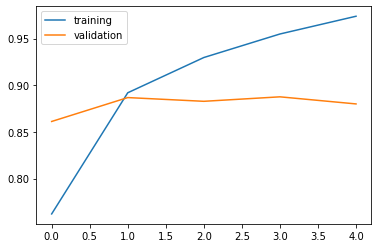

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
##########################################################
"""
《卷积三种模式》
https://zhuanlan.zhihu.com/p/62760780

三种不同模式是对卷积核移动范围的不同限制。

# full模式的意思是，从filter和image刚相交开始做卷积，白色部分为填0。

# same mode
当filter的中心(K)与image的边角重合时，开始做卷积运算，
可见filter的运动范围比full模式小了一圈。
注意：这里的same还有一个意思，卷积之后输出的feature map尺寸保持不变(相对于输入图片)。
当然，same模式不代表完全输入输出尺寸一样，也跟卷积核的步长有关系。
same模式也是最常见的模式，因为这种模式可以在前向传播的过程中让特征图的大小保持不变，
调参师不需要精准计算其尺寸变化(因为尺寸根本就没变化)。

# 当filter全部在image里面的时候，进行卷积运算，可见filter的移动范围较same更小了。

输入图片大小W×W
Filter大小F×F
步长S
padding的像素数P
N = (W − F+ 2P)/S+1 输出大小为N×N


# tf的padding有两个值，一个是SAME，一个是VALID

# 如果padding设置为SAME
则说明输入图片大小和输出图片大小是一致的，
padding = “SAME”输入和输出大小关系：
输出大小等于输入大小除以步长向上取整

# 如果是VALID则图片经过滤波器后可能会变小。
conv2d的VALID方式不会在原有输入的基础上添加新的像素。
n_out = (n_in - f + 1)/s
向上取整

"""
##########################################################